In [1]:
cd /Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo/

/Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo


In [2]:
import miniSAFE as ms
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec as gs
import networkx as nx
from matplotlib.collections import LineCollection
import OMEGA_core as om
from scipy import stats

In [3]:
# load dataframe
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
reshaped = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')
snf_data = pk.load(open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','rb'))
n_components = 20
positions = snf_data['positions']
g = snf_data['network']
pos = snf_data['embedding']
graph = snf_data['composite_graph']
func_tab = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/func_annot.xlsx',index_col='Functional_category')

In [4]:
# map entry ids of the original and selected entries
SAFE_entry_id = df.index[df['SAFE_input']==1].values
filtered_graph_data = graph[SAFE_entry_id,:][:,SAFE_entry_id]

cutoff = np.percentile(graph,90)
g = nx.Graph()
indices = np.where(filtered_graph_data>=cutoff)
gdata = np.zeros((len(indices[0]),2))
gdata[:,0]=indices[0]
gdata[:,1]=indices[1]

SAFE_entry_df = df.iloc[SAFE_entry_id].reset_index(drop=True)
SAFE_entry_df.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_SAFE_input.xlsx')

In [5]:
merge_thresholds = [0.2,0.5,0.85]
cf=89.9
safe_dict = {}

#kegg

kegg_dict = {}
for th in merge_thresholds:
    sf=ms.SAFE_pack(filtered_graph_data,
                    '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/msm_kegg.xls',
                    cf,
                    attribute_relative_distance_threshold=th,
                    enrichment_threshold=0.05,
                    attribute_enrichment_min_size=5,
                    input_df='/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_SAFE_input.xlsx')
    kegg_dict[th]=sf

#GO
go_dict = {}
for th in merge_thresholds:
    sf=ms.SAFE_pack(filtered_graph_data,
                    '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/msm_go.xls',
                    cf,attribute_relative_distance_threshold=th,enrichment_threshold=0.05,attribute_enrichment_min_size=5,
                    input_df='/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_SAFE_input.xlsx')
    go_dict[th]=sf


#cog
cog_dict = {}
for th in merge_thresholds:
    sf=ms.SAFE_pack(filtered_graph_data,
                    '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog_filtered.xls',
                    cf,geneset_attribute_key='Functional_category',
                    attribute_relative_distance_threshold=th,enrichment_threshold=0.05,attribute_enrichment_min_size=10,
                    input_df='/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_SAFE_input.xlsx')
    cog_dict[th]=sf

safe_dict['KEGG']=kegg_dict
safe_dict['GO']=go_dict
safe_dict['COG']=cog_dict
pk.dump(safe_dict,open( "/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SAFE/SAFE_dict.pk", "wb" ))

In [6]:
safe_dict = pk.load(open( "/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SAFE/SAFE_dict.pk", "rb" ))

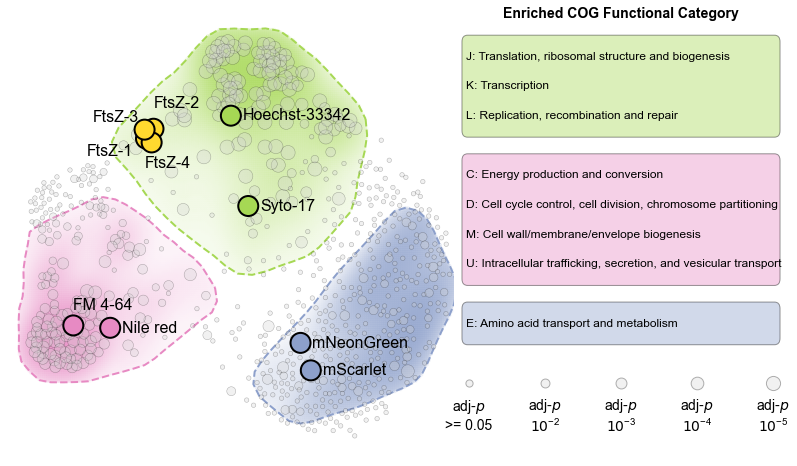

In [7]:
# using KEGG as reference
from matplotlib.patches import FancyBboxPatch

fig=plt.figure(figsize=(14,8))
grids = gs(8,14,hspace=0,wspace=0)
ax1 = fig.add_subplot(grids[:,:8])
ax2 = fig.add_subplot(grids[:-2,8:])
ax3 = fig.add_subplot(grids[-2:,8:])
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.3,ax=ax1)

sf = safe_dict['COG'][0.85]
sizes = sf.node2domain['primary_nes']/5
sizes[sizes>1]=1
sizes[sizes<-np.log10(0.05)/5]=0.1
full_sizes = np.ones(len(positions[0]))*0.1
full_sizes[SAFE_entry_id]=sizes

ax1.scatter(positions[0],positions[1],s=200*full_sizes,
            zorder=3,
            c='lightgrey', ec='black',lw=0.5,alpha=0.3)

# plot reference entries
idx = np.array([761,762,774,775,776,777,764,767,769,773])-1
labels = ['Nile red','Syto-17','mNeonGreen','mScarlet','FM 4-64',
          'Hoechst-33342','FtsZ-1','FtsZ-2','FtsZ-3','FtsZ-4']
colorlabels = [3,4,2,2,3,4,5,5,5,5]
ax1.scatter(positions[0,idx],positions[1,idx],s=400,
            c=cm.get_cmap('Set2')(colorlabels), 
            ec='black',lw=2,alpha=1,zorder=5)
offsets = [[0.05,0],[0.05,0],[0.05,0],
           [0.05,0],[0,0.08],[0.05,0],
           [-0.25,-0.05],[0.0,0.1],[-0.25,0.1],[0,-0.13]]
for i in range(len(idx)):
    x,y = offsets[i]
    ax1.text(positions[0,idx[i]]+x,positions[1,idx[i]]+y,s=labels[i],fontname='Arial',
             fontsize=16,ha='left',va='center')


domain_colors = [cm.get_cmap('Set2')(4),
                 cm.get_cmap('Set2')(3),
                 cm.get_cmap('Set2')(2),
                 cm.get_cmap('Set2')(1),
                 cm.get_cmap('Set2')(0),
                 cm.get_cmap('Set2')(5),
                 cm.get_cmap('Set2')(6)]

annotations = {}
n_annotations = 0
for i in range(1,len(sf.domains)):
    d=graph.copy()
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    basecolor = domain_colors[i-1]
    ax1 = ms.polygon_to_density(ax1,x,y,basecolor,alpha_max=0.4,
                                outline_lw=2,
                                outline_ls='--',smooth_outline=5)
    annotations[i]=sf.domains.iloc[i]['label'].split(' | ')
    n_annotations+=len(annotations[i])
    #coords = ms.scatter2outline(np.vstack([x,y]).T,base=10,ampl_factor=50)
    #plt.scatter(coords[:,0],coords[:,1])

top = 0.9
step = 1/(n_annotations+len(annotations))
for j,v in annotations.items():
    nitem = len(v)
    box = FancyBboxPatch((-0.05,top-nitem*step+0.5*step),height=nitem*step,width=1.1,boxstyle='Round,pad=0.02',
                         fc=domain_colors[j-1],alpha=0.4)
    ax2.add_artist(box)
    for k in range(nitem):
        key = v[k]
        fc_name = str(func_tab.loc[key,'Annotation'])
        ax2.text(-0.055,top,key+': '+fc_name,fontname='Arial',fontsize=12,ha='left',va='center')
        top -= step
    top -= step

vals = [-np.log10(0.05)/5,-np.log10(0.01)/5,-np.log10(0.001)/5,-np.log10(0.0001)/5,-np.log10(0.00001)/5]
texts = ['>= 0.05', '$10^\mathregular{-2}$', '$10^\mathregular{-3}$','$10^\mathregular{-4}$','$10^\mathregular{-5}$']
sizes = np.array(vals)*200
for counter,i in enumerate(np.linspace(0.1,0.9,5)):
    ax3.scatter(i,0.7,s=sizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3)
    ax3.text(i,0.4,'adj-$\it{p}$'+'\n{}'.format(texts[counter]),ha='center',va='center',fontname='Arial',fontsize=14)
ax3.set_ylim(0,1) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax2.set_title('Enriched COG Functional Category',fontname='Arial',fontsize=14,fontweight='bold')

ax1.set_xlim(-1.1,0.8)
ax1.set_ylim(-0.75,0.95)
ax2.set_ylim(0,1)
ax2.set_xlim(-0.1,1.1)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/SAFE/COG_cutoff0.85.png',
            dpi=160,bbox_inches='tight',transparent=True)

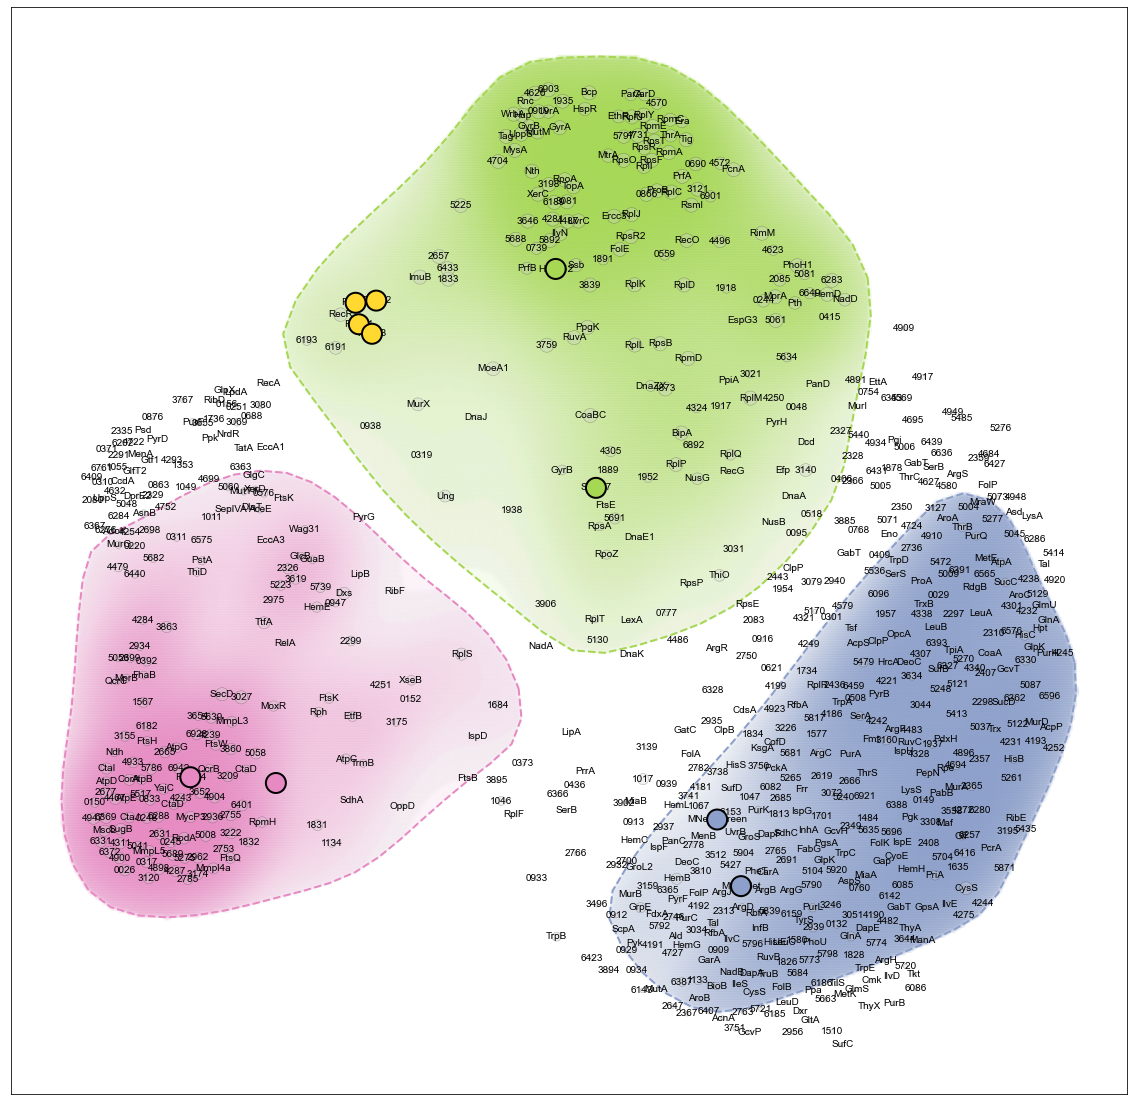

In [8]:
def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n.split('_')[1])
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

fig = plt.figure(figsize=(20,20))
ax1=plt.subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 0.5 

for i,s in enumerate(format_names(df['name'].values)):
    x=positions[0,i]
    y=positions[1,i]
    plt.annotate(s,(x,y),fontname='Arial',fontsize=10,va='center',ha='center')

sf = safe_dict['COG'][0.85]
sizes = sf.node2domain['primary_nes']/5
sizes[sizes>1]=1
sizes[sizes<-np.log10(0.05)/5]=0.1
full_sizes = np.ones(len(positions[0]))*0.1
full_sizes[SAFE_entry_id]=sizes

edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1, width=0.3,ax=ax1)
ax1.scatter(positions[0],positions[1],s=200*full_sizes,
            zorder=3,
            c='lightgrey', ec='black',lw=0.5,alpha=0.3)

# plot reference entries
idx = np.array([761,762,774,775,776,777,764,767,769,773])-1
labels = ['Nile red','Syto-17','mNeonGreen','mScarlet','FM 4-64',
          'Hoechst-33342','FtsZ-1','FtsZ-2','FtsZ-3','FtsZ-4']
colorlabels = [3,4,2,2,3,4,5,5,5,5]
ax1.scatter(positions[0,idx],positions[1,idx],s=400,
            c=cm.get_cmap('Set2')(colorlabels), 
            ec='black',lw=2,alpha=1,zorder=5)


domain_colors = [cm.get_cmap('Set2')(4),
                 cm.get_cmap('Set2')(3),
                 cm.get_cmap('Set2')(2),
                 cm.get_cmap('Set2')(1),
                 cm.get_cmap('Set2')(0),
                 cm.get_cmap('Set2')(5),
                 cm.get_cmap('Set2')(6)]

annotations = {}
n_annotations = 0
for i in range(1,len(sf.domains)):
    d=graph.copy()
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    basecolor = domain_colors[i-1]
    ax1 = ms.polygon_to_density(ax1,x,y,basecolor,alpha_max=0.4,
                                density_plot_point_size=50,ngrid=1000,
                                outline_lw=2,
                                outline_ls='--',smooth_outline=10)
    annotations[i]=sf.domains.iloc[i]['label'].split(' | ')
    n_annotations+=len(annotations[i])
    #coords = ms.scatter2outline(np.vstack([x,y]).T,base=10,ampl_factor=50)
    #plt.scatter(coords[:,0],coords[:,1])

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/SAFE/full_map.png',
            dpi=160,bbox_inches='tight',transparent=True)

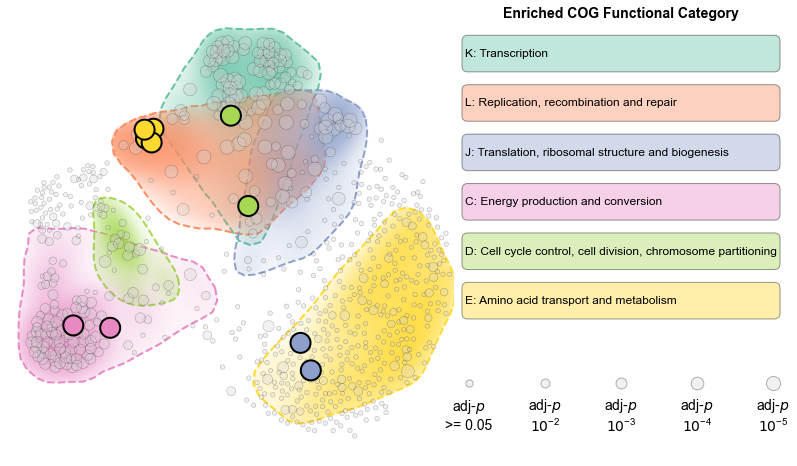

In [9]:
# using KEGG as reference
from matplotlib.patches import FancyBboxPatch

fig=plt.figure(figsize=(14,8))
grids = gs(8,14,hspace=0,wspace=0)
ax1 = fig.add_subplot(grids[:,:8])
ax2 = fig.add_subplot(grids[:-2,8:])
ax3 = fig.add_subplot(grids[-2:,8:])
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.3,ax=ax1)

sf = safe_dict['COG'][0.2]
sizes = sf.node2domain['primary_nes']/5
sizes[sizes>1]=1
sizes[sizes<-np.log10(0.05)/5]=0.1
full_sizes = np.ones(len(positions[0]))*0.1
full_sizes[SAFE_entry_id]=sizes

ax1.scatter(positions[0],positions[1],s=200*full_sizes,
            zorder=3,
            c='lightgrey', ec='black',lw=0.5,alpha=0.3)

# plot reference entries
idx = np.array([761,762,774,775,776,777,764,767,769,773])-1
labels = ['Nile red','Syto-17','mNeonGreen','mScarlet','FM 4-64',
          'Hoechst-33342','FtsZ-1','FtsZ-2','FtsZ-3','FtsZ-4']
colorlabels = [3,4,2,2,3,4,5,5,5,5]
ax1.scatter(positions[0,idx],positions[1,idx],s=400,
            c=cm.get_cmap('Set2')(colorlabels), 
            ec='black',lw=2,alpha=1,zorder=5)


domain_colors = [cm.get_cmap('Set2')(i) for i in range(10)]

annotations = {}
n_annotations = 0
for i in range(1,len(sf.domains)):
    d=graph.copy()
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    basecolor = domain_colors[i-1]
    ax1 = ms.polygon_to_density(ax1,x,y,basecolor,alpha_max=0.4,
                                outline_lw=2,
                                outline_ls='--',smooth_outline=5)
    annotations[i]=sf.domains.iloc[i]['label'].split(' | ')
    n_annotations+=len(annotations[i])
    #coords = ms.scatter2outline(np.vstack([x,y]).T,base=10,ampl_factor=50)
    #plt.scatter(coords[:,0],coords[:,1])

top = 0.9
step = 1/(n_annotations+len(annotations))
for j,v in annotations.items():
    nitem = len(v)
    box = FancyBboxPatch((-0.05,top-nitem*step+0.5*step),height=nitem*step,width=1.1,boxstyle='Round,pad=0.02',
                         fc=domain_colors[j-1],alpha=0.4)
    ax2.add_artist(box)
    for k in range(nitem):
        key = v[k]
        fc_name = str(func_tab.loc[key,'Annotation'])
        ax2.text(-0.06,top,key+': '+fc_name,fontname='Arial',fontsize=12,ha='left',va='center')
        top -= step
    top -= step

vals = [-np.log10(0.05)/5,-np.log10(0.01)/5,-np.log10(0.001)/5,-np.log10(0.0001)/5,-np.log10(0.00001)/5]
texts = ['>= 0.05', '$10^\mathregular{-2}$', '$10^\mathregular{-3}$','$10^\mathregular{-4}$','$10^\mathregular{-5}$']
sizes = np.array(vals)*200
for counter,i in enumerate(np.linspace(0.1,0.9,5)):
    ax3.scatter(i,0.7,s=sizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3)
    ax3.text(i,0.4,'adj-$\it{p}$'+'\n{}'.format(texts[counter]),ha='center',va='center',fontname='Arial',fontsize=14)
ax3.set_ylim(0,1) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax2.set_title('Enriched COG Functional Category',fontname='Arial',fontsize=14,fontweight='bold')

ax1.set_xlim(-1.1,0.8)
ax1.set_ylim(-0.75,0.95)
ax2.set_ylim(-0.1,1)
ax2.set_xlim(-0.1,1.1)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/SAFE/COG_cutoff0.2.png',
            dpi=160,bbox_inches='tight',transparent=True)

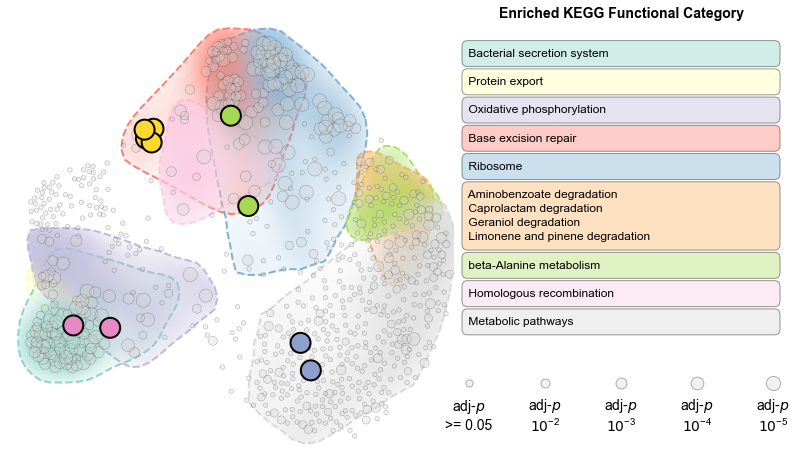

In [10]:
# using KEGG as reference
from matplotlib.patches import FancyBboxPatch

fig=plt.figure(figsize=(14,8))
grids = gs(8,14,hspace=0,wspace=0)
ax1 = fig.add_subplot(grids[:,:8])
ax2 = fig.add_subplot(grids[:-2,8:])
ax3 = fig.add_subplot(grids[-2:,8:])
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.1,ax=ax1)

sf = safe_dict['KEGG'][0.2]
sizes = sf.node2domain['primary_nes']/5
sizes[sizes>1]=1
sizes[sizes<-np.log10(0.05)/5]=0.1
full_sizes = np.ones(len(positions[0]))*0.1
full_sizes[SAFE_entry_id]=sizes

ax1.scatter(positions[0],positions[1],s=200*full_sizes,
            zorder=3,
            c='lightgrey', ec='black',lw=0.5,alpha=0.3)

# plot reference entries
idx = np.array([761,762,774,775,776,777,764,767,769,773])-1
labels = ['Nile red','Syto-17','mNeonGreen','mScarlet','FM 4-64',
          'Hoechst-33342','FtsZ-1','FtsZ-2','FtsZ-3','FtsZ-4']
colorlabels = [3,4,2,2,3,4,5,5,5,5]
ax1.scatter(positions[0,idx],positions[1,idx],s=400,
            c=cm.get_cmap('Set2')(colorlabels), 
            ec='black',lw=2,alpha=1,zorder=5)


domain_colors = [cm.get_cmap('Set3')(i) for i in range(10)]

annotations = {}
n_annotations = 0
for i in range(1,len(sf.domains)):
    d=graph.copy()
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    basecolor = domain_colors[i-1]
    ax1 = ms.polygon_to_density(ax1,x,y,basecolor,alpha_max=0.4,
                                outline_lw=2,
                                outline_ls='--',smooth_outline=5)
    annotations[i]=sf.domains.iloc[i]['label'].split(' | ')
    n_annotations+=len(annotations[i])
    #coords = ms.scatter2outline(np.vstack([x,y]).T,base=10,ampl_factor=50)
    #plt.scatter(coords[:,0],coords[:,1])

top = 0.9
step = 1/(n_annotations+len(annotations))
for j,v in annotations.items():
    nitem = len(v)
    box = FancyBboxPatch((-0.05,top-nitem*step+0.5*step),height=nitem*step,width=1.1,boxstyle='Round,pad=0.02',
                         fc=domain_colors[j-1],alpha=0.4)
    ax2.add_artist(box)
    for k in range(nitem):
        key = v[k]
        ax2.text(-0.06,top,key,fontname='Arial',fontsize=12,ha='left',va='center')
        top -= step
    top -= step

vals = [-np.log10(0.05)/5,-np.log10(0.01)/5,-np.log10(0.001)/5,-np.log10(0.0001)/5,-np.log10(0.00001)/5]
texts = ['>= 0.05', '$10^\mathregular{-2}$', '$10^\mathregular{-3}$','$10^\mathregular{-4}$','$10^\mathregular{-5}$']
sizes = np.array(vals)*200
for counter,i in enumerate(np.linspace(0.1,0.9,5)):
    ax3.scatter(i,0.7,s=sizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3)
    ax3.text(i,0.4,'adj-$\it{p}$'+'\n{}'.format(texts[counter]),ha='center',va='center',fontname='Arial',fontsize=14)
ax3.set_ylim(0,1) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax2.set_title('Enriched KEGG Functional Category',fontname='Arial',fontsize=14,fontweight='bold')

ax1.set_xlim(-1.1,0.8)
ax1.set_ylim(-0.75,0.95)
ax2.set_ylim(-0.1,1)
ax2.set_xlim(-0.1,1.1)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/SAFE/KEGG_cutoff0.2.png',
            dpi=160,bbox_inches='tight',transparent=True)

IndexError: index 777 is out of bounds for axis 1 with size 777

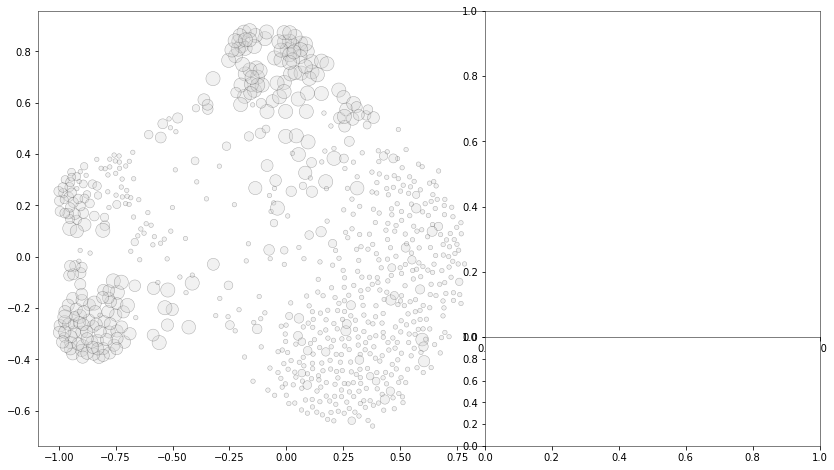

In [11]:
# using KEGG as reference
from matplotlib.patches import FancyBboxPatch

fig=plt.figure(figsize=(14,8))
grids = gs(8,14,hspace=0,wspace=0)
ax1 = fig.add_subplot(grids[:,:8])
ax2 = fig.add_subplot(grids[:-2,8:])
ax3 = fig.add_subplot(grids[-2:,8:])
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.1,ax=ax1)

sf = safe_dict['GO'][0.2]
sizes = sf.node2domain['primary_nes']/5
sizes[sizes>1]=1
sizes[sizes<-np.log10(0.05)/5]=0.1
full_sizes = np.ones(len(positions[0]))*0.1
full_sizes[SAFE_entry_id]=sizes

ax1.scatter(positions[0],positions[1],s=200*full_sizes,
            zorder=3,
            c='lightgrey', ec='black',lw=0.5,alpha=0.3)

# plot reference entries
idx = np.array([761,762,774,775,776,777,764,767,769,773])
labels = ['Nile red','Syto-17','mNeonGreen','mScarlet','FM 4-64',
          'Hoechst-33342','FtsZ-1','FtsZ-2','FtsZ-3','FtsZ-4']
colorlabels = [3,4,2,2,3,4,5,5,5,5]
ax1.scatter(positions[0,idx],positions[1,idx],s=400,
            c=cm.get_cmap('Set2')(colorlabels), 
            ec='black',lw=2,alpha=1,zorder=5)


domain_colors = [cm.get_cmap('Set2')(i) for i in range(10)]

annotations = {}
n_annotations = 0
for i in range(1,len(sf.domains)):
    d=graph.copy()
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    basecolor = domain_colors[i-1]
    ax1 = ms.polygon_to_density(ax1,x,y,basecolor,alpha_max=0.4,
                                outline_lw=2,
                                outline_ls='--',smooth_outline=5)
    annotations[i]=sf.domains.iloc[i]['label'].split(' | ')
    n_annotations+=len(annotations[i])
    #coords = ms.scatter2outline(np.vstack([x,y]).T,base=10,ampl_factor=50)
    #plt.scatter(coords[:,0],coords[:,1])

top = 0.9
step = 1/(n_annotations+len(annotations))
for j,v in annotations.items():
    nitem = len(v)
    box = FancyBboxPatch((-0.05,top-nitem*step+0.5*step),height=nitem*step,width=1.1,boxstyle='Round,pad=0.02',
                         fc=domain_colors[j-1],alpha=0.4)
    ax2.add_artist(box)
    for k in range(nitem):
        key = v[k]
        ax2.text(-0.06,top,key,fontname='Arial',fontsize=12,ha='left',va='center')
        top -= step
    top -= step

vals = [-np.log10(0.05)/5,-np.log10(0.01)/5,-np.log10(0.001)/5,-np.log10(0.0001)/5,-np.log10(0.00001)/5]
texts = ['>= 0.05', '$10^\mathregular{-2}$', '$10^\mathregular{-3}$','$10^\mathregular{-4}$','$10^\mathregular{-5}$']
sizes = np.array(vals)*200
for counter,i in enumerate(np.linspace(0.1,0.9,5)):
    ax3.scatter(i,0.7,s=sizes[counter],fc='lightgrey', ec='black',lw=1,alpha=0.3)
    ax3.text(i,0.4,'adj-$\it{p}$'+'\n{}'.format(texts[counter]),ha='center',va='center',fontname='Arial',fontsize=14)
ax3.set_ylim(0,1) 
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax2.set_title('Enriched GO Functional Category',fontname='Arial',fontsize=14,fontweight='bold')

ax1.set_xlim(-1.1,0.8)
ax1.set_ylim(-0.75,0.95)
ax2.set_ylim(-0.1,1)
ax2.set_xlim(-0.1,1.1)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/safe_GO_lowcutoff.png',
            dpi=160,bbox_inches='tight',transparent=True)

In [288]:
go = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/msm_go.xls')
go_translation=[]
for k in set(go['geneset'].values):
    if 'translation' in k:
        go_translation+= list(go[go['geneset']==k]['locus'].values)
go_translation = list(set(go_translation))

msr_translation_id = []
for l in list(set(go_translation) & set(df['locus'].values)):
    msr_translation_id.append(df[df['locus']==l].index[0])
msr_translation_id = np.array(msr_translation_id)

novel = np.array(list(set(ribo_enriched)-set(ribo_index[ribo_index>=0])))
unmapped = np.array(list(set(ribo_index[ribo_index>=0])-set(ribo_enriched)))
ribo_mapped = np.array(list(set(ribo_index[ribo_index>=0])&set(ribo_enriched)))
ribo_all = np.array(list(set(ribo_index[ribo_index>=0])|set(ribo_enriched)))

In [335]:
def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n.split('_')[1])
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

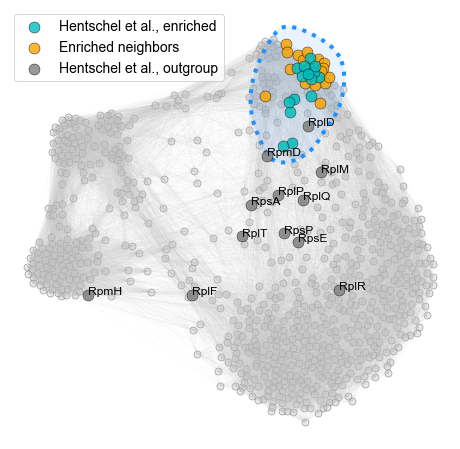

In [404]:
fig = plt.figure(figsize=(8,8))
plt.scatter(positions[0],positions[1],s=50,
            c='lightgrey', ec='black',lw=0.5,alpha=0.5)
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.5)

plt.axis('off')

# mapped ribosomal proteins


plt.scatter(positions[0,ribo_mapped],positions[1,ribo_mapped],s=120,
            fc='c', ec='black',lw=0.5,alpha=0.8,zorder=3,label='Hentschel et al., enriched')

plt.scatter(positions[0,novel],positions[1,novel],s=120,zorder=2,
            c='orange', ec='black',lw=0.5,alpha=0.8, label='Enriched neighbors')

plt.scatter(positions[0,unmapped],positions[1,unmapped],s=120,zorder=2,
            c='grey', ec='black',lw=0.5,alpha=0.8,label='Hentschel et al., outgroup')

outline = ms.miniSAFE.scatter2outline(positions[:,ribo_enriched].T,base=100,ampl_factor=40)
plt.fill(outline[:,0],outline[:,1],c='dodgerblue',alpha=0.1,zorder=1)
plt.plot(outline[:,0],outline[:,1],c='dodgerblue',lw=4,ls=':',zorder=1)

plt.legend(prop={'family':'Arial','size':14})

for i,s in enumerate(format_names(df.iloc[unmapped]['name'].values)):
    plt.text(x=positions[0,unmapped[i]],y=positions[1,unmapped[i]],s=s,fontname='Arial',fontsize=12)
    
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/REDO_SAFE/Ribosome_global.png',
            dpi=100,bbox_inches='tight',transparent=True)

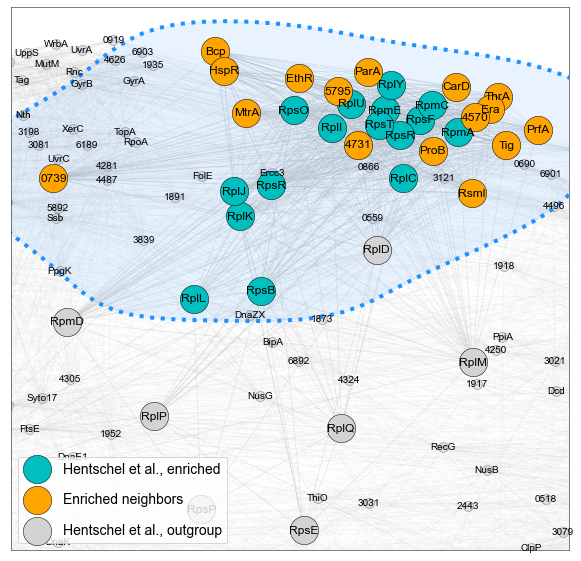

In [415]:
fig = plt.figure(figsize=(10,10))
ax=plt.subplot(111)
outgroup = np.array(list(set(df.index.values)-set(ribo_all)))
plt.scatter(positions[0,outgroup],positions[1,outgroup],s=100,
            c='lightgrey', ec='black',lw=0.5,alpha=0.5)
for i,s in enumerate(format_names(df.iloc[outgroup]['name'].values)):
    x=positions[0,outgroup[i]]
    y=positions[1,outgroup[i]]
    if np.logical_and(x<0.32,x>0) & np.logical_and(y<0.9,y>0):
        plt.annotate(s,(x,y),fontname='Arial',fontsize=10,va='center',ha='center')
        
        
nx.draw_networkx_edges(g.subgraph(outgroup),pos=pos,edge_color='silver',alpha=0.1,width=0.5)
nx.draw_networkx_edges(g.subgraph(ribo_all),pos=pos,edge_color='silver',alpha=0.5,width=0.5)

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 0.5
ax.set_xticks([])
ax.set_yticks([])

# mapped ribosomal proteins
plt.scatter(positions[0,ribo_mapped],positions[1,ribo_mapped],s=800,
            fc='c', ec='black',lw=0.5,alpha=1,zorder=3,label='Hentschel et al., enriched')

plt.scatter(positions[0,novel],positions[1,novel],s=800,
            c='orange', ec='black',lw=0.5,alpha=1,zorder=3,label='Enriched neighbors')

plt.scatter(positions[0,unmapped],positions[1,unmapped],s=800,
            c='lightgrey', ec='black',lw=0.5,alpha=1,zorder=3,label='Hentschel et al., outgroup')

outline = ms.miniSAFE.scatter2outline(positions[:,ribo_enriched].T,base=100,ampl_factor=60)
plt.fill(outline[:,0],outline[:,1],c='dodgerblue',alpha=0.1,zorder=1)
plt.plot(outline[:,0],outline[:,1],c='dodgerblue',lw=4,ls=':',zorder=1)

for i,s in enumerate(format_names(df.iloc[all_ribo]['name'].values)):
    x=positions[0,all_ribo[i]]
    y=positions[1,all_ribo[i]]
    if np.logical_and(x<0.32,x>0) & np.logical_and(y<0.9,y>0):
        plt.annotate(s,(x,y),fontname='Arial',fontsize=12,va='center',ha='center')

plt.legend(prop={'family':'Arial','size':14},labelspacing=1.2)
plt.xlim(0,0.32)
plt.ylim(0,0.92)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/REDO_SAFE/Ribosome_zoomin.png',
            dpi=100,bbox_inches='tight',transparent=True)

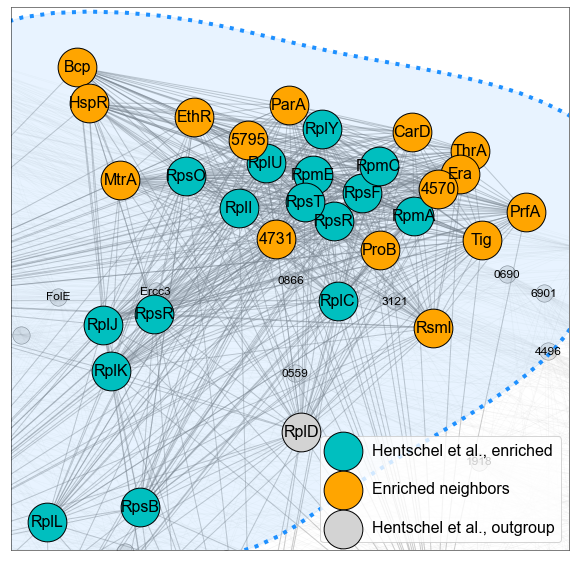

In [414]:
fig = plt.figure(figsize=(10,10))
ax=plt.subplot(111)
outgroup = np.array(list(set(df.index.values)-set(ribo_all)))
plt.scatter(positions[0,outgroup],positions[1,outgroup],s=300,
            c='lightgrey', ec='black',lw=0.5,alpha=0.5)
for i,s in enumerate(format_names(df.iloc[outgroup]['name'].values)):
    x=positions[0,outgroup[i]]
    y=positions[1,outgroup[i]]
    if np.logical_and(x<0.32,x>0.1) & np.logical_and(y<0.9,y>0.4):
        plt.annotate(s,(x,y),fontname='Arial',fontsize=12,va='center',ha='center')
        
        
nx.draw_networkx_edges(g.subgraph(outgroup),pos=pos,edge_color='silver',alpha=0.1,width=0.5)
nx.draw_networkx_edges(g.subgraph(ribo_all),pos=pos,edge_color='gray',alpha=0.4,width=1)

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 0.5
ax.set_xticks([])
ax.set_yticks([])
#plt.axis('off')
# mapped ribosomal proteins
plt.scatter(positions[0,ribo_mapped],positions[1,ribo_mapped],s=1500,
            fc='c', ec='black',lw=1,alpha=1,zorder=3,label='Hentschel et al., enriched')

plt.scatter(positions[0,novel],positions[1,novel],s=1500,
            c='orange', ec='black',lw=1,alpha=1,zorder=3,label='Enriched neighbors')

plt.scatter(positions[0,unmapped],positions[1,unmapped],s=1500,
            c='lightgrey', ec='black',lw=1,alpha=1,zorder=3,label='Hentschel et al., outgroup')

outline = ms.miniSAFE.scatter2outline(positions[:,ribo_enriched].T,base=100,ampl_factor=60)
plt.fill(outline[:,0],outline[:,1],c='dodgerblue',alpha=0.1,zorder=1)
plt.plot(outline[:,0],outline[:,1],c='dodgerblue',lw=4,ls=':',zorder=1)

for i,s in enumerate(format_names(df.iloc[all_ribo]['name'].values)):
    x=positions[0,all_ribo[i]]
    y=positions[1,all_ribo[i]]
    if np.logical_and(x<0.32,x>0.1) & np.logical_and(y<0.9,y>0.4):
        plt.annotate(s,(x,y),fontname='Arial',fontsize=16,va='center',ha='center')

plt.legend(prop={'family':'Arial','size':16},labelspacing=1.5,loc='lower right')
plt.xlim(0.09,0.32)
plt.ylim(0.4,0.9)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/REDO_SAFE/Ribosome_zoomin2.png',
            dpi=100,bbox_inches='tight',transparent=True)

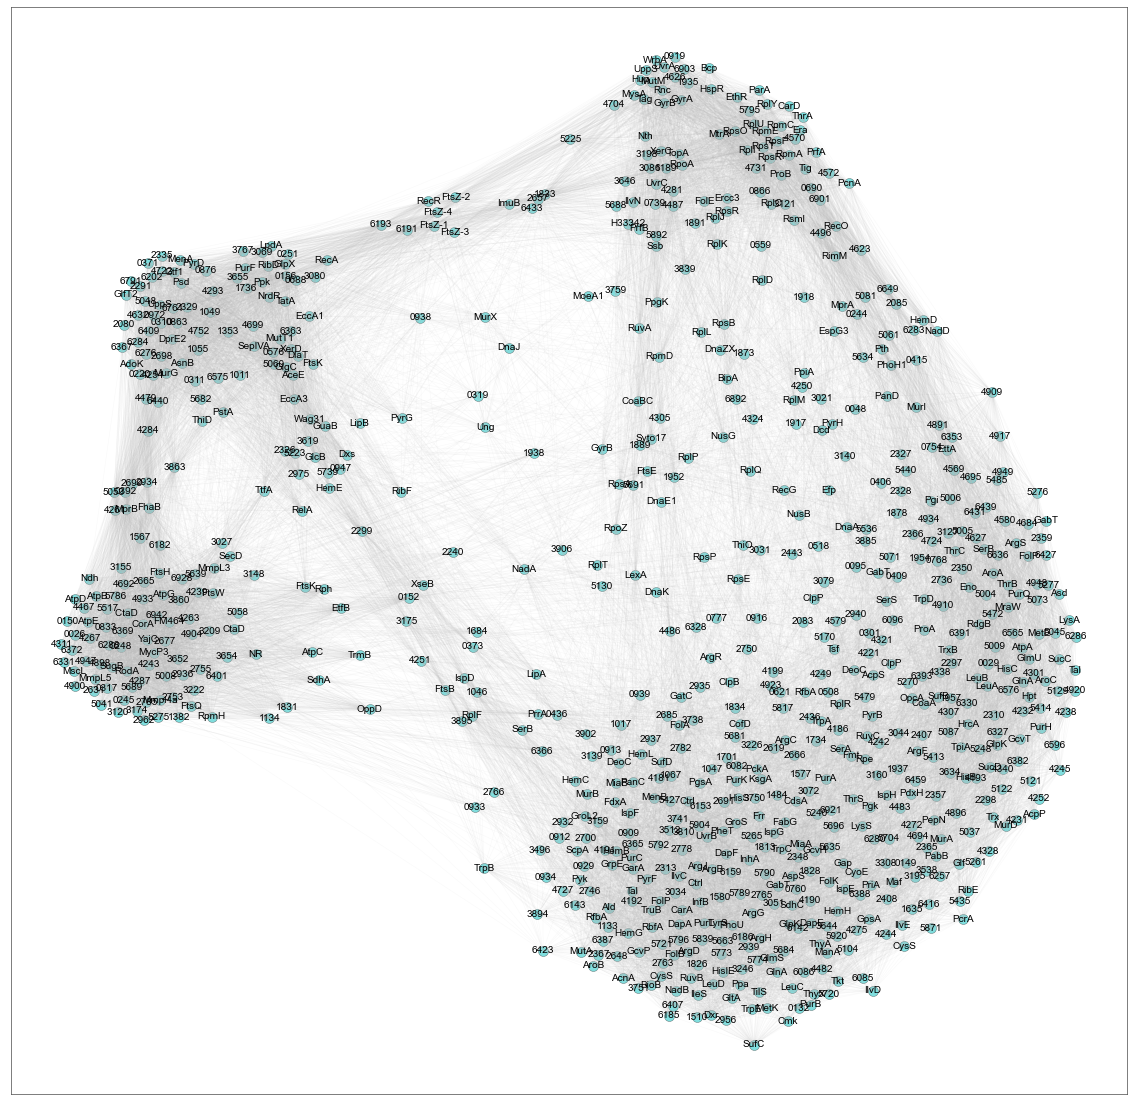

In [418]:
fig = plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ax.set_xticks([])
ax.set_yticks([])
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 0.5 
plt.scatter(positions[0],positions[1],s=100,
            c='c', ec='black',lw=0.5,alpha=0.5)
for i,s in enumerate(format_names(df['name'].values)):
    x=positions[0,i]
    y=positions[1,i]
    plt.annotate(s,(x,y),fontname='Arial',fontsize=10,va='center',ha='center')
nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.5)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/REDO_SAFE/full_map.png',
            dpi=100,bbox_inches='tight',transparent=True)

In [389]:
def LRFP_reader(folder,key):
    import glob
    import tifffile
    for file in glob.glob(folder+'*.png'):
        if key in file:
            return plt.imread(file)
            break

In [386]:
df[df['locus']=='MSMEG_6363'].index[0]

700

In [22]:
cols = ['locus','NCBI_assembly','protein_id','length','coordinates','length_of_coordinates','COG','reserved','COG membership class','PSI-BLAST bit score','eval','COG profile length','Protein footprint coordinates']
msm_cog = open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog.csv','w')
msm_cog.write(','.join(cols)+'\n')
with open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/cog-20.cog.csv','r') as cog:
    while True:
        line = cog.readline()
        if 'MSMEG' in line:
            msm_cog.write(line)
        if line == '':
            break
cog.close()
msm_cog.close()

In [27]:
msm_cog = pd.read_csv('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog.csv')
msm_cog.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog.xls')

In [203]:
msm_cog = pd.read_csv('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog.csv')
fc = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/COG_def.xls',index_col='COG')
fc_annotation=[]
for s in msm_cog['COG'].values:
    fc_annotation.append(fc.loc[s,'Functional_categry'])
msm_cog['Functional_category'] = fc_annotation
msm_cog.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog.xls')

In [ ]:
msm_cog.head()

In [260]:
# split cog
split_cog = msm_cog.copy()
new_fc = list(split_cog['Functional_category'].values)
new_items = []
for i in range(len(msm_cog)):
    l = list(msm_cog.iloc[i].values)
    if len(l[-1]) > 1:
        new_fc[i] = l[-1][0]
        for k in range(1,len(l[-1])):
            newl = l.copy()
            newl[-1] = l[-1][k]
            new_items.append(newl)
split_cog['Functional_category'] = new_fc
new_items = pd.DataFrame(new_items, columns=split_cog.columns)
split_cog.append(new_items)
sorted_df = split_cog.sort_values(by='locus')
sorted_df.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog_singleset.xls')

In [284]:
filtered_cog = sorted_df[(sorted_df['Functional_category']!='R')&(sorted_df['Functional_category']!='S')]
filtered_cog.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/msm_cog_filtered.xls')

In [37]:
counter=0
for sf in somanycogs:
    for i in range(1,len(sf.domains)):
        fig=plt.figure(figsize=(8,8))
        ax = plt.subplot(111)
        nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.1,width=0.5)
        plt.scatter(positions[0],positions[1],s=50,
                    c='lightgrey', ec='black',lw=0.5,alpha=0.5)
        
        d=graph.copy()
        #targets = np.concatenate([ribo_proteins,np.array([537,600])])
        targets = np.where(sf.node2domain['primary_domain']==i)[0]
        original_idx = SAFE_entry_id[targets]
        target_edges, weights = format_edges(original_idx,positions,d,cutoff=cutoffs[counter])
        normalized_weight_m=min_max_normalization(np.array(weights),pad=0.01)
        edge_colors = cm.get_cmap('Blues')(np.array(weights))
        edge_lines = LineCollection(target_edges,color=edge_colors,lw=normalized_weight_m*2,
                                    zorder=2,alpha=0.2)
        ax.add_collection(edge_lines)
        node_colors = cm.get_cmap('Blues')(cutoffs[counter]*sf.node2domain.iloc[targets]['primary_nes']/10)
        x,y = positions[0,original_idx],positions[1,original_idx]
        xy = np.vstack([x,y])
        density = stats.gaussian_kde(xy)(xy)
        plt.scatter(x,y,s=300,
                    c=cm.get_cmap('coolwarm')(min_max_normalization(density,pad=0)*0.9), 
                    ec='black',lw=1,alpha=0.5,zorder=3)
        outline = ms.miniSAFE.scatter2outline(positions[:,original_idx].T,base=100,ampl_factor=30)
        plt.fill(outline[:,0],outline[:,1],c='dodgerblue',alpha=0.1,zorder=1)
        plt.plot(outline[:,0],outline[:,1],c='dodgerblue',lw=4,ls=':',zorder=1)
        plt.axis('off')
        plt.xlim(-1.2,0.9)
        plt.ylim(-0.85,1)
        plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/REDO_SAFE/SAFE_COG_cutoff{}_{}.png'.format(round(cutoffs[counter],5),
                                                                                                                           sf.domains.iloc[i]['label'][:50]),
                    dpi=100,bbox_inches='tight',transparent=True)
        plt.close()
    counter+=1